In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import urllib.request
from pytrends.request import TrendReq
import pandas as pd

class Trend:
    def __init__(self, keyword, timeframe, data_url):
        self._keyword = keyword
        self._timeframe = timeframe
        self._data_url = data_url

        self._api_df = None
        self._user_df = None

        self._api_row_count = None
        self._user_row_count = None
        self._user_col_count = None

        self.get_api_data()
        self.parse_api_df()
        self.parse_data_url()

    def get_api_data(self):
        pytrends.build_payload(kw_list=[self._keyword], timeframe=[self._timeframe])
        self._api_df = pytrends.interest_over_time()

    def parse_api_df(self):
        self._api_df[self._keyword] = self._api_df[self._keyword] / 100
        self._api_df = self._api_df.reset_index()
        self._api_df['user_values'] = np.nan
        self._api_row_count = len(self._api_df)

    def parse_data_url(self):
        image_data = urllib.request.urlopen(self._data_url)
        image = Image.open(image_data).convert('L')
        data = np.array(image)

        self._user_df = pd.DataFrame(data)
        self._user_row_count = len(self._user_df)
        self._user_col_count = len(self._user_df.columns)

    def calculate_score(self):
        relevant = self._user_df[self._user_df.columns[self._user_df.mean(axis=0) > 0]]

        for column_idx in relevant:
            line_values = self._user_df[column_idx][self._user_df[column_idx] != 0]

            if len(line_values) > 0:
                corresponding_row = int(column_idx / self._user_col_count * self._api_row_count)
                mean = (self._user_row_count - line_values.index.values.mean()) / self._user_row_count
                self._api_df.at[corresponding_row, 'user_values'] = mean

        # self._api_df['user_values'] = self._api_df['user_values'].interpolate(method='linear', axis=0)

        # if self._api_df['user_values'].isnull().values.any():
        #     self._api_df['user_values'] = self._api_df['user_values'].bfill(axis=0)
        #     self._api_df['user_values'] = self._api_df['user_values'].ffill(axis=0)

        self._api_df['difference'] = np.square((self._api_df['user_values'] - self._api_df[self._keyword]))
        self._api_df['difference'] = self._api_df['difference'].fillna(value=1, axis=0)

        mean_squared_error = (self._api_df['difference'].sum()) / self._api_row_count
        return (1 - mean_squared_error) * 100

    def visualise_result(self):
        self._api_df['user_values'].plot()

    def visualise_api(self):
        self._api_df[self._keyword].plot()


In [ ]:
data_url = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAFkCAYAAABGnFibAAAAAXNSR0IArs4c6QAAH1hJREFUeF7t3Y1120YWBlCikmwqSVJJkkqyW0m8lWxSySaVaP20HAeBQREkgQ9/V+f42JJIPODOs48+z2DQXXwQIECAAAECBAgQIECAQESgi1RRhAABAgQIECBAgAABAgQuApgmIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAAAv2wNvb2z8ul0v9+u5a9vte+fp6ffyx0CndOn6rV7//2TuHP7quW+pcFrpEhyVAgAABAgQIECCwbQEB7IXxGQSqfpgaO+q9779wJou+tR/Q6s+/t5DWdd1vi1Z2cAIECBAgQIAAAQIHExDAJgzoNWjVKytEfXP9fa+BasIVP/SSCmXtl3D2EJ0XEyBAgAABAgQInE1AABsZ8Wvg+vG6XPCnszXFjNc7nD2rQw+XOr5/zXLHGdUdigABAgQIECBAYLMCAlhvaK7B65fPgWCp0NWfLWpBpB9S6mzavVpzN02rMzx++7xm9tqf271qS53LR9dmyePcI+94BAgQIECAAAECmxEQwC6XyzV4/XpdWvjI4LRA1e6FakvwvjrGXu+XGiy/rOuqDUTWCmgtnPW9a/bMvWiPdK3XEiBAgAABAgQIrCZw+gB2DRj/nTAC9cN//aD/Zebq7D/498JZf3fHNmuWvkdu6nLHGur311r2OKHrvYQAAQIECBAgQGBWgdMGsAmzXvVD+qfa9e/sQevZjhsJaHWo4VLH+loLcM+WeuV9wyWgdnp8RdN7CRAgQIAAAQIEPhQ4ZQC7M+tVP4D/LHTl/+bcCGxrLnlsCHZ6zLeDigQIECBAgACBQwqcKoBNmPX61HXdz4cc6QNcVO+5a/2HWdef08sd+5r3lj7Wa/sPtLb88QC96BIIECBAgAABAs8KnCKA9baVr90Nx3b2M+v1bAdt5H0PLHesM+7v9rj2FVgCufYIqE+AAAECBAgQCAqcJYD954NZErNewYbbWqk7yx7rdNecXWtco7s/en7a1rrJ+RAgQIAAAQIE7gscPoDdud/rWzvh3W+Ss79iZOnjWtvwjw3FzeemCWhn71zXT4AAAQIECGxR4PABrNDf3t7GZsBqo43a5dAHgacFJix9rGP3l72mlz+O3aNWz6tr96J5htrTo++NBAgQIECAAIHHBc4SwOrer3rQcn0IXo/3iXcsJLCRJZDDkPblWXfXy66HXfc3EllIw2EJECBAgAABAscXOEUAq2GsH3T9EHn8hj7iFQ6WQLbnqK2x++OjOz7WcNj18YhN6ZoIECBAgACBpwVOE8CeFvJGAhsW6M2gtc1C6rlp9bFGQJsqNbbzY3/WzYzbVEmvI0CAAAECBHYnIIDtbsicMIHpAiNLHPszaG0zkekHzL3Szo85a5UIECBAgACBoIAAFsRWisAWBUZm0fohrU55C1vxD+nGZtHaa8ae9df/2lcPxr5cLrUxSX3U7JuNSbbYqM6JAAECBAgcREAAO8hAugwCSwoMZtKqVAs0LayNhZ+x3R+XPM05jz22vb+dI+cUdiwCBAgQIHBSAQHspAPvsgmsJfDBzo8t2G1xxm3I9ciGJO5pW6vZ1CVAgAABAhsUEMA2OChOicDZBTa08+PcQ3Fr6eSXJZAeoD03ueMRIECAAIFtCQhg2xoPZ0OAwASBXkBrr751j1f7fv++r+HSyP4yyi3tHun5bBN6wUsIECBAgMDeBASwvY2Y8yVAYHGBG9v7t10jxzb5WPycPijw0XLIL9/zHMQ1h0htAgQIECDwl4AAphsIECDwoMCN+9iGM2n92bmthLbhDpD98PZne3C2ZZAPNoSXEyBAgACBBwQEsAewvJQAAQKvCNzYTXIY3Lb0fLZ7ga04zLK90hTeS4AAAQKnExDATjfkLpgAgT0I7PT5bI321mYj7es12/a38FafWCa5h850jgQIECDwqoAA9qqg9xMgQGBFgcGGJG2p43fXU2qfb2lW7Z7WrWew2c7/npzvEyBAgMAuBASwXQyTkyRAgMDrAh88UHsvga2Fs98ul0tt3V+fC2avt4YjECBAgEBQQAALYitFgACBPQl8ENjGNhxZc5ZtbCfI9my1Inef2p4az7kSIEDg4AIC2MEH2OURIEAgLXAnuNXp9JdGts/TO0Va6phuDPUIECBA4F1AANMIBAgQILAJgRvb+9fyyPQDst+XNl5/vS917Lqulj36IECAAAECLwsIYC8TOgABAgQIJAR6G45UIFsrmLUgJpglBl0NAgQIHFBAADvgoLokAgQInElgZOasf49aUSy9G2TNlglmZ2o610qAAIEXBASwF/C8lQABAgT2KTCYTauLWGJGTTDbZ3s4awIECCwqIIAtyuvgBAgQILA3gcBSR/eY7a0pnC8BAgRmFBDAZsR0KAIECBA4pkBvmeP319myutC5NwcxY3bM9nFVBAgQ+JuAAKYhCBAgQIDAkwKBYPbVw6ftyPjkYHkbAQIENiIggG1kIJwGAQIECBxHIBTMbPxxnJZxJQQiAtd/m365zuDXvyH/7rqu/UdP5BwU8RwwPUCAAAECBGICCwczs2WxkVSIwP4Erv/+/Pp519ZaSt0+fuu67of9Xc2+z9gM2L7Hz9kTIECAwAEERoLZnPeXtXvL6vffLWE8QMO4BAITBa7/tvx4DV394NWOUA+a/3bi4bxsJgEBbCZIhyFAgAABAnMLLLgjo1A292A5HoGNCEwIXf0z/cF/yuQHTgDLm6tIgAABAgSeFlhwtswujE+PijcSWEeg95809SzDmuEam+W6dXI/d133aZ0zP3dVAezc4+/qCRAgQOAgAgvNlnlm2UH6w2XsX+DFsNUA6u/0vz4Htbr3y+YbK7WFALYSvLIECBAgQGBpAbNlSws7PoHlBB5cSvjRiVTQqpkuOx4uN1wPHVkAe4jLiwkQIECAwL4FFg5lhVNbW/9+uVzq5v62Vf6+0Zw9gZDA29tbe9j7P18o2WaubTP/AuKSbxXAltR1bAIECBAgsAOBBUNZXX27t0wo20EvOMWsQG+Wq3Y+/enJ6m2Gq95up9MnEZNvE8CS2moRIECAAIEdCSx4X5mZsh31gVOdV+D696pmur75fORHZ7qErXmHY5WjCWCrsCtKgAABAgT2KbDQbNlwB0YbBOyzPZz1iMAgcD26U2ELXGa2DtRdAtiBBtOlECBAgACBtQQWmC2zA+Nag6nuwwK9/5iohx7XRwWtWlZYvx75ELge0drpawWwnQ6c0yZAgAABAlsXWHC2rIWzuq+sPt4/t6321jviOOc34w6FrX/tUnic9rh7JQLYXSIvIECAAAECBOYSmOlZRh+dTnu2UQtp7QfcP3th7f1rAttco3r848wcuPqhy9LC47fPV1cogJ1w0F0yAQIECBDYkkDvHpnvrku2avlW6qMf2NoPxvW1Cmzv37OdfmootlHnxXu2xi6ivy18fd/zuLYx1KudhQC2Gr3CBAgQIECAwC2BQSirl9W9NMlgNjy14cya5Y87b9+RoPXMPVt9hbaZzJcAL7zvvEkWOn0BbCFYhyVAgAABAgTmFRjcU1YHrxmzFs5e/eF5jpO1/HEOxRmPMeiZ2vb92c0xxgJ5Pei4xtwywhnH7AyHEsDOMMqukQABAgQInECg98N223mu/V4/eA+/tqXAVqNjY5EbPToSoqaO3Zwzpv1lhALXCf49WfISBbAldR2bAAECBAgQ2LTAILQNA1v7Qf/RrcTnvubhfWpzH3/Lx5szRE29zuE9WwLXVDmvmyQggE1i8iICBAgQIEDgzAI7WP545uF59toFrWflvO8lAQHsJT5vJkCAAAECBAj8X6C3xX59emv543ApJL7lBfpB6313S5tjLI+uwm0BAUx3ECBAgAABAgRWELix/HFrG4usIDNa8qvZqnsnJmTdE/L9tQQEsLXk1SVAgAABAgQITBAY2VxkwrsO8xIPzD7MULqQJiCA6QUCBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAkIYCFoZQgQIECAAAECBAgQICCA6QECBAgQIECAAAECBAiEBASwELQyBAgQIECAAAECBAgQEMD0AAECBAgQIECAAAECBEICAlgIWhkCBAgQIECAAAECBAgIYHqAAAECBAgQIECAAAECIQEBLAStDAECBAgQIECAAAECBAQwPUCAAAECBAgQIECAAIGQgAAWglaGAAECBAgQIECAAAECApgeIECAAAECBAgQIECAQEhAAAtBK0OAAAECBAgQIECAAAEBTA8QIECAAAECBAgQIEAgJCCAhaCVIUCAAAECBAgQIECAgACmBwgQIECAAAECBAgQIBASEMBC0MoQIECAAAECBAgQIEBAANMDBAgQIECAAAECBAgQCAn8DzveAJI1eut1AAAAAElFTkSuQmCC"

In [ ]:

import urllib.request
from PIL import Image
import numpy as np
import pandas as pd
image_data = urllib.request.urlopen(data_url)
image = Image.open(image_data).convert('L')
data = np.array(image)

_user_df = pd.DataFrame(data)

relevant = _user_df[_user_df.columns[_user_df.mean(axis=0) > 0]]

print(relevant)

c:\Users\Python\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


<Axes: xlabel='date'>

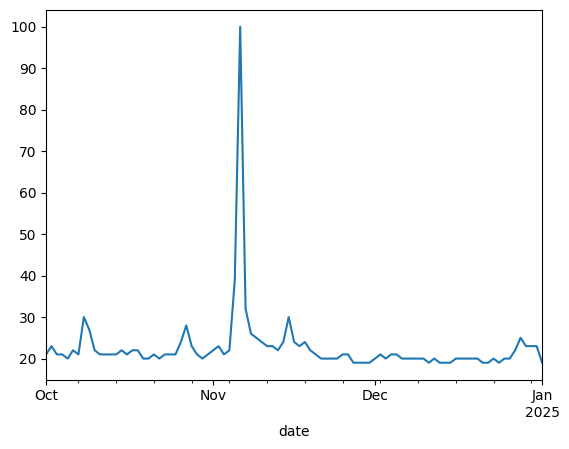

In [3]:

pytrends.build_payload(kw_list=['robert'], timeframe=['today 3-m'])
df = pytrends.interest_over_time()
df['robert'].plot()

In [35]:
pd.set_option('display.max_rows', 500)
trend._api_df['mega']

0     0.09
1     0.12
2     0.10
3     0.12
4     0.11
5     0.11
6     0.10
7     0.09
8     0.11
9     0.09
10    0.11
11    0.13
12    0.10
13    0.10
14    0.09
15    0.12
16    0.12
17    0.10
18    0.12
19    0.13
20    0.10
21    0.10
22    0.12
23    0.10
24    0.12
25    0.12
26    0.12
27    0.11
28    0.10
29    0.14
30    0.12
31    0.14
32    0.16
33    0.11
34    0.10
35    0.11
36    0.14
37    0.12
38    0.16
39    0.15
40    0.17
41    0.11
42    0.10
43    0.12
44    0.11
45    0.10
46    0.12
47    0.12
48    0.10
49    0.10
50    0.13
51    0.11
52    0.11
53    0.12
54    0.17
55    0.12
56    0.10
57    0.13
58    0.10
59    0.13
60    0.13
61    0.13
62    0.11
63    0.11
64    0.15
65    0.11
66    0.12
67    0.14
68    0.14
69    0.11
70    0.11
71    0.16
72    0.13
73    0.14
74    0.16
75    0.13
76    0.13
77    0.15
78    0.22
79    0.15
80    0.14
81    0.21
82    0.14
83    0.14
84    0.18
85    0.36
86    0.23
87    0.26
88    0.57
89    0.21
90    0.26

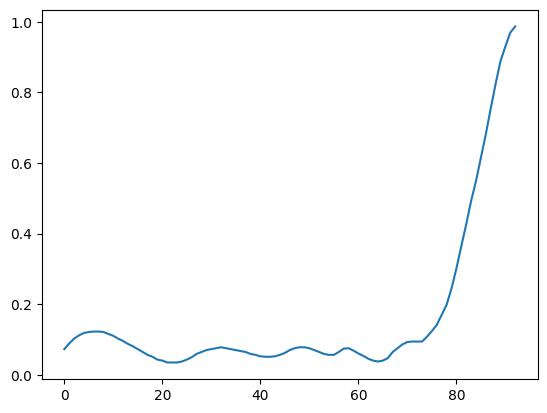

In [36]:
trend.visualise_result()

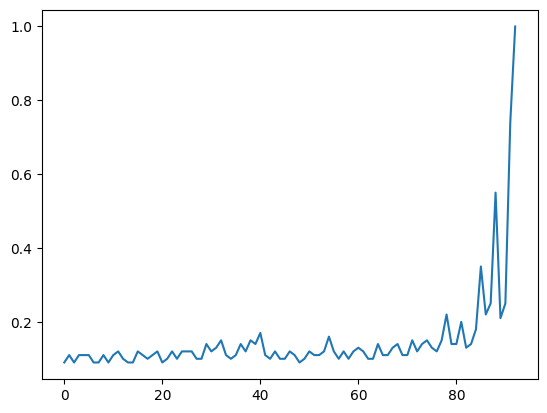

In [9]:
trend.visualise_api()